# Information Retrieval using BM-25
#### [CISI Dataset](https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval)

In [ ]:
import numpy as np
import pandas as pd
import os
#Libraries for Preprocessing
import re #for regex removal
import nltk
nltk.download('punkt') #for tokenization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords #for removing stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer #for lemmatization
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
#from functools import reduce #concatenate words into sentence using reduce
#Libraries for BM25
from rank_bm25 import BM25Okapi

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1.Load Dataset Files Data into dictionaries <a id='load_data'></a>

In [ ]:
path = r"data\datasets\semantic_search"

In [ ]:
#_____________ Read data from CISI.ALL file and store in dictinary ________________
with open(os.path.join(path, 'CISI.ALL')) as f:
    lines = ""
    for l in f.readlines():
        # add new line char for lines starting with (.) and add space for other lines
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    #split a string into list based on newline(\n) separator.
    lines = lines.lstrip("\n").split("\n")

# Put each DOCUMENT into a dictionary doc_set
doc_set = {}
doc_id = ""
doc_text = ""
for l in lines:
    if l.startswith(".I"):
        doc_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
    elif l.startswith(".X"):
        # indicate document ending
        doc_set[doc_id] = doc_text.lstrip(" ")
        doc_id = ""
        doc_text = ""
    else:
        # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
        doc_text += l.strip()[3:] + " "

print(f"Number of documents = {len(doc_set)}")
print(doc_set["1"]) # note that the dictionary indexes are strings, not numbers.

Number of documents = 1460
18 Editions of the Dewey Decimal Classifications Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. 


In [ ]:
#_____________ Read data from CISI.QRY file and store in dictinary ________________
with open(os.path.join(path, 'CISI.QRY')) as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")

# Put each QUERY into a dictionary doc_set.
qry_set = {}
qry_id = ""
for l in lines:
    if l.startswith(".I"):
        qry_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
    elif l.startswith(".W"):
        # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
        qry_set[qry_id] = l.strip()[3:]
        qry_id = ""

print(f"Number of queries = {len(qry_set)}")
print(qry_set["1"]) # note that the dictionary indexes are strings, not numbers.

Number of queries = 112
What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?


In [ ]:
#_____________ Read data from CISI.REL file and store in dictinary ________________
rel_set = {}
with open(os.path.join(path, 'CISI.REL')) as f:
    for l in f.readlines():
        qry_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0] #split("\t")[0] -> '1     28'
        doc_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1] #                 [0]   [-1]

        if qry_id in rel_set:
            rel_set[qry_id].append(doc_id)
        else:
            rel_set[qry_id] = []
            rel_set[qry_id].append(doc_id)

print(f"Number of mappings = {len(rel_set)}")
print(rel_set["1"]) # note that the dictionary indexes are strings, not numbers.

Number of mappings = 76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '195', '215', '269', '291', '320', '429', '465', '466', '482', '483', '510', '524', '541', '576', '582', '589', '603', '650', '680', '711', '722', '726', '783', '813', '820', '868', '869', '894', '1162', '1164', '1195', '1196', '1281']


## 2.Data Wrangling
Preprocess Documents and Queries Data


In [ ]:
#Customize stopwords list
for i in ["not", "no"]:
    stop_words.remove(i)
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_docs(doc):
    #1. Removing upper brackets to keep words like [user\'s]
    doc = doc.replace("\'", "")
    #2. Removing symbols and numbers
    doc = re.sub(r"[^a-zA-Z]+", ' ', doc).strip()

    #3. Convert string to tokens, lowercase it & remove stop words
    tokens = word_tokenize(doc)  #to convert a string to tokens
    tokens = tokens = [w.lower() for w in tokens if w.lower() not in stop_words and len(w)>1]

    #4. Convert word to its base form
    lemmatized_tokens = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

    return lemmatized_tokens

In [ ]:
def preprocess_corpus(data):
    docs = {id: preprocess_docs(doc) for (id, doc) in data.items()}
    return docs

In [ ]:
# preprocessing documents
preprocessed_doc_dict = preprocess_corpus(doc_set)
print(f"first preprocessed doc: \n{preprocessed_doc_dict['1']}")

first preprocessed doc: 
['edition', 'dewey', 'decimal', 'classification', 'comaromi', 'present', 'study', 'history', 'dewey', 'decimal', 'classification', 'first', 'edition', 'ddc', 'publish', 'eighteenth', 'edition', 'future', 'edition', 'continue', 'appear', 'need', 'spite', 'ddc', 'long', 'healthy', 'life', 'however', 'full', 'story', 'never', 'tell', 'biography', 'dewey', 'briefly', 'describe', 'system', 'first', 'attempt', 'provide', 'detailed', 'history', 'work', 'spur', 'growth', 'librarianship', 'country', 'abroad']


In [ ]:
# preprocessing queries
preprocessed_qry_dict = preprocess_corpus(qry_set)
print(f"first preprocessed query: \n{preprocessed_qry_dict['1']}")

first preprocessed query: 
['problem', 'concern', 'make', 'descriptive', 'title', 'difficulty', 'involve', 'automatically', 'retrieve', 'article', 'approximate', 'title', 'usual', 'relevance', 'content', 'article', 'title']


## 3.Data Modeling <a id='train_ir_system'></a>

### 3.1 Train BM25Okapi model

In [ ]:
# BM25Okapi class receives a list of lists of strings, which are the document tokens.
bm25 = BM25Okapi(preprocessed_doc_dict.values())
#key->query_id, value->list of doc scores
doc_scores = {id: bm25.get_scores(query) for (id, query) in preprocessed_qry_dict.items()}

In [ ]:
#Sort retrieved document_ids by scores
docid_sortedBy_score = {} #key-> query_id, value-> list of doc_id in descending order of doc scores
for query_id in doc_scores:
    doc_score_dict = {} # dictionary, key->doc_id and value->doc score
    for score, doc_id in zip(doc_scores[query_id], doc_set):
        doc_score_dict[doc_id] = round(score, 3)
    # sort doc_id based on scores, high score first
    docid_sortedBy_score[query_id] = sorted(doc_score_dict, key=doc_score_dict.get, reverse=True)

## 4.Performance Metrics (For Top-10 Results)

In [ ]:
K = 10

#### 4.1 Precision@K

In [ ]:
# Precision@K = TP/(TP+FP)
def precision_k(predictions, ground_truth, k):
    truth_set = set(ground_truth) #set doesn't maintain order of id's
    pred_set = set(predictions[:k])
    result = round(len(truth_set & pred_set) / float(len(pred_set)), 3) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    return result

In [ ]:
# Mean Precision@K
def mean_precision(predictions, ground_truth, k):
    precision_lst = [precision_k(predictions.get(qry_id), doc_ids, k) for (qry_id,doc_ids) in ground_truth.items()]
    mean_prec = sum(precision_lst) / len(ground_truth)
    return round(mean_prec, 3)

In [ ]:
print(f"Precision@{K} = {mean_precision(docid_sortedBy_score, rel_set, K)}")

Precision@10 = 0.349


#### 4.2 Recall@K

In [ ]:
# Recall@K = TP/(TP+FN)
def recall_k(predictions, ground_truth, k):
    truth_set = set(ground_truth) #set doesn't maintain order of id's
    pred_set = set(predictions[:k])
    result = round(len(truth_set & pred_set) / float(len(truth_set)), 3) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    return result

In [ ]:
# Mean Recall@K
def mean_recall(predictions, ground_truth, k):
    recall_lst = [recall_k(docid_sortedBy_score.get(qry_id), doc_ids, k) for (qry_id,doc_ids) in rel_set.items()]
    mean_rec = sum(recall_lst) / len(rel_set)
    return round(mean_rec, 3)

In [ ]:
print(f"Recall@{K} = {mean_recall(docid_sortedBy_score, rel_set, K)}")

Recall@10 = 0.151


#### 4.3 Mean Reciprocal Rank (MRR)

In [ ]:
# first occurance of true positive i.e. index of first actual relevant docid predicted.
def get_first_relevent_docid(predictions, truth):
    first_relevent_ocurrence = [predictions.index(doc_id)+1 for doc_id in predictions if doc_id in truth]
    return len(truth)+1 if len(first_relevent_ocurrence)==0 else first_relevent_ocurrence[0]

In [ ]:
def mrr_score(predictions, truth):
    #index of first actual relevant docid predicted
    reciprocals = [(1 / get_first_relevent_docid(predictions[qry_id], truth[qry_id])) for (qry_id,_) in truth.items()]
    # mean of summation of cumulative_reciprocal
    mrr = 1/len(rel_set) * sum(reciprocals)
    return round(mrr, 3)

In [ ]:
print(f"Mean Reciprocal Rank (MRR) = {mrr_score(docid_sortedBy_score, rel_set)}")

Mean Reciprocal Rank (MRR) = 0.624


#### 4.4 Mean Average Precision (MAP)

In [ ]:
def average_precision_k(predictions, truth, K):
    avg_precision_lst = [precision_k(truth, predictions, k+1) * (predictions[k] in truth) for k in range(K)]
    return sum(avg_precision_lst) / len(truth)

In [ ]:
def map_score(predictions, truth, K):
    average_precision = [average_precision_k(predictions[qry_id], truth[qry_id], K) for (qry_id,_) in truth.items()]
    map_k = sum(average_precision) / len(truth) # mean of all AP values of a query
    return round(map_k, 3)

In [ ]:
print(f"MAP@10 = {map_score(docid_sortedBy_score, rel_set, K)}")

MAP@10 = 0.151


## 5.BM-25 Different Parameters <a id='bm25_parameters'></a>


#####  **k1: when do we think a term is likely to be saturated?**
- long docs/books of particular domain and diverse text can have a term appear multiple times even when it's not primary subject of the document. k1 should be large.
- collection of short tweets can have a term appear multiple times only when its related. k1 should be small.

#####  **b: when do we think a document is likely to be very long, and when should that hinder its relevance to a term**
- subject specific docs may be lengthy but its length doesnt lower its relevance. b should be small.
- general docs like news article, reviews length lowers its elevance. b should be large.

##### **Documents in this CISI corpus are domain specific i.e. related to library, literature, information gathering, relevance, indexing and length is between 99 to 4000. So,**
- k1 should be large/ medium
- b should be small

In [ ]:
from numpy import arange
# Generate float numbers. k1->0 to 3, b->0 to 1
k1_values = [round(val,2) for val in arange(0.1, 3.1, 0.15)]
b_values = [round(val,2) for val in arange(0.1, 1.1, 0.1)]
print(f"k1_values: {k1_values}, count: {len(k1_values)}")
print(f"b_values: {b_values}, count: {len(b_values)}")

k1_values: [0.1, 0.25, 0.4, 0.55, 0.7, 0.85, 1.0, 1.15, 1.3, 1.45, 1.6, 1.75, 1.9, 2.05, 2.2, 2.35, 2.5, 2.65, 2.8, 2.95], count: 20
b_values: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], count: 10


In [ ]:
def custom_parameters_bm25(k1=1.5, b=0.75):
    from rank_bm25 import BM25Okapi

    bm25 = BM25Okapi(preprocessed_doc_dict.values(), k1=k1, b=b) # default k1=1.5, b=0.75, epsilon=0.25
    doc_scores = {id: bm25.get_scores(query) for (id, query) in preprocessed_qry_dict.items()}

    docid_sortedBy_score = {} #key-> query_id, value-> list of doc_id in descending order of doc scores
    for query_id in doc_scores:
        doc_score_dict = {} # dictionary, key-> doc_id and value->doc score
        for score, doc_id in zip(doc_scores[query_id], doc_set):
            doc_score_dict[doc_id] = round(score, 3)
        docid_sortedBy_score[query_id] = sorted(doc_score_dict, key=doc_score_dict.get, reverse=True)
    return docid_sortedBy_score

In [ ]:
#Train BM-25 with different parameter values
bm25_scores = []
parameter_values = [(k1, b) for k1 in k1_values for b in b_values]
for (k1,b) in parameter_values:
    predictions = custom_parameters_bm25(k1, b)

    precision = mean_precision(predictions, rel_set, K)
    recall = mean_recall(predictions, rel_set, K)
    mrr = mrr_score(predictions, rel_set)
    map_k = map_score(predictions, rel_set, K)
    bm25_scores.append([precision, recall, mrr, map_k])

In [ ]:
# Create new Dataframe
model_names = [f"k1_{k1};b_{b}" for (k1,b) in parameter_values]
#k1_column = [k1 for (k1,_) in parameter_values]
#b_column = [b for (_,b) in parameter_values]
precision_column = [lst[0] for lst in bm25_scores]
recall_column = [lst[1] for lst in bm25_scores]
mrr_column = [lst[2] for lst in bm25_scores]
map_column = [lst[3] for lst in bm25_scores]

data = {'model_name': model_names,
       'precision_k': precision_column,
       'recall_k': recall_column,
       'mrr': mrr_column,
       'map_k': map_column}

df_performance = pd.DataFrame(data)

In [ ]:
#Sort dataframe and retrieve models with max. MAP@10 score
max_map_val = max([lst[3] for lst in bm25_scores])
df_top_parameter_values = df_performance.sort_values(by=['map_k', 'mrr', 'precision_k', 'recall_k'], ascending=False)
                                        .loc[df_performance['map_k'] >= max_map_val]
df_top_parameter_values

,model_name,precision_k,recall_k,mrr,map_k
107,k1_1.6;b_0.8,0.349,0.151,0.642,0.154
117,k1_1.75;b_0.8,0.347,0.151,0.640,0.154
127,k1_1.9;b_0.8,0.346,0.151,0.640,0.154
98,k1_1.45;b_0.9,0.347,0.151,0.635,0.154
137,k1_2.05;b_0.8,0.345,0.151,0.634,0.154


### 5.1. Visualization of diff. k1 and b values

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

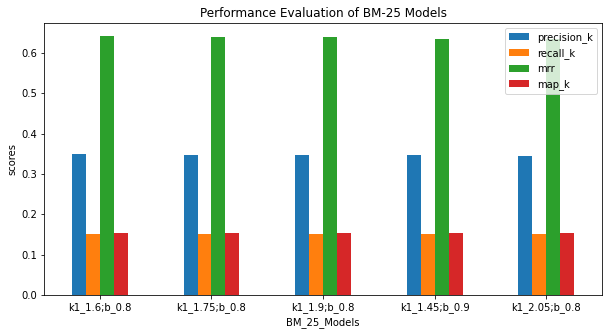

In [ ]:
df_top_parameter_values.plot.bar(x='model_name', rot=0, figsize=(10,5))
plt.title('Performance Evaluation of BM-25 Models')
plt.xlabel('BM_25_Models')
plt.ylabel('scores')
plt.show()

###### Best model parameters : k1 = 1.6 , b = 0.8

## 6.BM-25 Variations <a id='bm25_variations'></a>
[BM25Okapi, BM25L, BM25Plus]

In [ ]:
#Sort retrieved document_ids by scores
def get_sorted_docid_per_query(doc_scores, doc_set):
    docid_sortedBy_score = {} #key-> query_id, value-> list of doc_id in descending order of doc scores
    for query_id in doc_scores:
        doc_score_dict = {} # dictionary, key->doc_id and value->doc score
        for score, doc_id in zip(doc_scores[query_id], doc_set):
            doc_score_dict[doc_id] = round(score, 3)
        # sort doc_id based on scores, high score first
        docid_sortedBy_score[query_id] = sorted(doc_score_dict, key=doc_score_dict.get, reverse=True)
    return docid_sortedBy_score

In [ ]:
# Train models
from rank_bm25 import BM25Okapi
from rank_bm25 import BM25L
from rank_bm25 import BM25Plus

# BM25 subclasses receives a list of lists of strings, which are the document tokens.
bm25okapi_model = BM25Okapi(preprocessed_doc_dict.values())  # k1=1.5, b=0.75, epsilon=0.25
bm25l_model = BM25L(preprocessed_doc_dict.values()) # k1=1.5, b=0.75, delta=0.5
bm25plus_model = BM25Plus(preprocessed_doc_dict.values()) # k1=1.5, b=0.75, delta=1

ir_models = [bm25okapi_model, bm25l_model, bm25plus_model]
ir_model_names = ['bm25okapi', 'bm25l', 'bm25plus']

ir_models_sorted_docids = {} #key->modelname, value->dictionary
for i,model in enumerate(ir_models):
    doc_scores = {}  #key->query_id, value->list of doc scores
    for qry_id in preprocessed_qry_dict:
        doc_scores[qry_id] = model.get_scores(preprocessed_qry_dict[qry_id])
    ir_models_sorted_docids[ir_model_names[i]] = get_sorted_docid_per_query(doc_scores, doc_set)

In [ ]:
#Create dataframe
model_names = [model for model in list(ir_models_sorted_docids.keys())]
precision_lst = [mean_precision(docs, rel_set, K) for (model_name, docs) in ir_models_sorted_docids.items()]
recall_lst = [mean_recall(docs, rel_set, K) for (model_name, docs) in ir_models_sorted_docids.items()]
mrr_lst = [mrr_score(docs, rel_set) for (model_name, docs) in ir_models_sorted_docids.items()]
map_lst = [map_score(docs, rel_set, K) for (model_name, docs) in ir_models_sorted_docids.items()]

data = {'model_name': model_names,
        'precision_k': precision_lst,
        'recall_k': recall_lst,
        'mrr': mrr_lst,
        'map_k': map_lst}
df_bm25_models = pd.DataFrame(data)

In [ ]:
df_bm25_models

,model_name,precision_k,recall_k,mrr,map_k
0,bm25okapi,0.349,0.151,0.624,0.151
1,bm25l,0.266,0.151,0.462,0.101
2,bm25plus,0.351,0.151,0.648,0.151


### 6.1.Visualization of BM-25 variations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = {'model': ['BM25Okapi', 'BM25L', 'BM25Plus'],
        'Recall@10': [0.151, 0.151, 0.151],
        'Precision@10': [ 0.349, 0.266, 0.351],
        'MRR': [0.624, 0.462, 0.648],
        'MAP@10': [0.151, 0.101, 0.151]
        }

df_performance = pd.DataFrame(data)
df_performance

,model,Recall@10,Precision@10,MRR,MAP@10
0,BM25Okapi,0.151,0.349,0.624,0.151
1,BM25L,0.151,0.266,0.462,0.101
2,BM25Plus,0.151,0.351,0.648,0.151


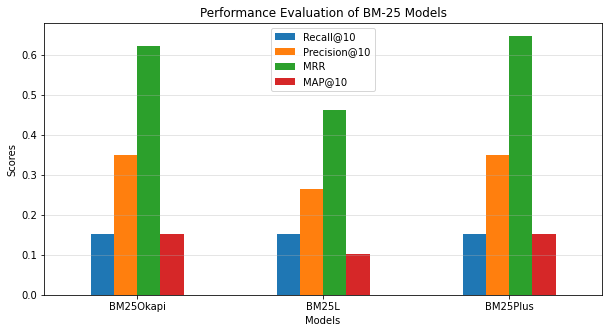

In [ ]:
df_performance.plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Performance Evaluation of BM-25 Models')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

#### Best model: BM25Plus